In [45]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matyplotlib -rf

Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
Sudo媛� �씠 而댄벂�꽣�뿉�꽌 �궗�슜�븯吏� �븡�룄濡� �꽕�젙�릺�뼱 �엳�뒿�땲�떎. �궗�슜�븯�룄濡� �꽕�젙�븯�젮硫� �쑝濡� �씠�룞�븯�꽭�슂. ]8;;ms-settings:developers\Developer Settings page]8;;\ �꽕�젙 �빋�쓽
'rm'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [46]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import random

sns.set_style("whitegrid")

BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"

eval_df = pd.read_csv(BASE/"eval_2025_pred_vs_actual.csv", parse_dates=["target_date"])
pred_df = pd.read_csv(BASE/"predictions.csv", parse_dates=["target_date"])
fea_df  = pd.read_csv(BASE/"features_all.csv", parse_dates=["target_date"])
sku_info = pd.read_csv(BASE/"sku_catalog_ml_with_share.csv")


In [48]:
# eval: actual(y), pred_lgb(y_pred)
eval_df = eval_df.rename(columns={"y":"actual", "y_pred":"pred_lgb"})

pred_df = pred_df.rename(columns={"y_pred":"pred_ens"})

df = eval_df.merge(
    pred_df[["sku_id","target_date","pred_ens"]],
    on=["sku_id","target_date"],
    how="left"
)

df = df.merge(
    sku_info[["sku_id","cat_low"]],
    on="sku_id",
    how="left"
)

df.dropna(subset=["pred_ens"], inplace=True)
df.head()


,target_date,sku_id,actual,pred_lgb,pred_ens,cat_low
50,2025-12-22,1,42,51.213096,40.036122,TV
51,2025-12-29,1,35,41.458667,37.793321,TV
102,2025-12-22,2,2,2.443737,1.962986,TV
103,2025-12-29,2,2,1.962986,1.962986,TV
154,2025-12-22,3,2,2.474380,1.962981,TV


In [49]:
def mape(a, f):
    a, f = np.array(a), np.array(f)
    return np.mean(np.abs((a - f) / np.maximum(a, 1))) * 100

# MAE
mae_lgb = np.mean(np.abs(df["actual"] - df["pred_lgb"]))
mae_ens = np.mean(np.abs(df["actual"] - df["pred_ens"]))

# MAPE
mape_lgb = mape(df["actual"], df["pred_lgb"])
mape_ens = mape(df["actual"], df["pred_ens"])

print("=== 전체 성능 비교 ===")
print(f"LightGBM MAE  : {mae_lgb:.3f}")
print(f"Ensemble MAE  : {mae_ens:.3f}")
print(f"LightGBM MAPE : {mape_lgb:.3f}%")
print(f"Ensemble MAPE : {mape_ens:.3f}%")


=== 전체 성능 비교 ===
LightGBM MAE  : 2.938
Ensemble MAE  : 1.848
LightGBM MAPE : 13.705%
Ensemble MAPE : 9.432%


In [50]:
cat_mape = (
    df.groupby("cat_low")
      .apply(lambda g: mape(g["actual"], g["pred_ens"]))
      .reset_index(name="MAPE_ens")
)

cat_mape_lgb = (
    df.groupby("cat_low")
      .apply(lambda g: mape(g["actual"], g["pred_lgb"]))
      .reset_index(name="MAPE_lgb")
)

cat_compare = cat_mape.merge(cat_mape_lgb, on="cat_low")
cat_compare["Improved"] = cat_compare["MAPE_lgb"] - cat_compare["MAPE_ens"]

cat_compare


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31096\3771457524.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mape(g["actual"], g["pred_ens"]))
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31096\3771457524.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: mape(g["actual"], g["pred_lgb"]))


,cat_low,MAPE_ens,MAPE_lgb,Improved
0,TV,4.171111,15.065330,10.894219
1,건조기,18.052345,18.581084,0.528739
2,공기청정기,3.103862,5.620337,2.516475
3,냉장고,2.915098,3.065093,0.149995
4,노트북,9.100295,10.893095,1.792800
5,데스크탑,19.902399,27.665115,7.762716
6,라우터,3.098777,3.919462,0.820684
7,모니터,10.199166,21.987145,11.787979
8,믹서기,8.870047,15.030888,6.160841
9,세탁기,16.020757,16.492605,0.471848


In [51]:
sku_stats = (
    df.groupby("sku_id")
      .apply(lambda g: pd.Series({
          "mape_lgb": mape(g["actual"], g["pred_lgb"]),
          "mape_ens": mape(g["actual"], g["pred_ens"])
      }))
).reset_index()

sku_stats["improved"] = sku_stats["mape_lgb"] > sku_stats["mape_ens"]

print("향상된 SKU 개수:", sku_stats["improved"].sum())
print("악화된 SKU 개수:", (~sku_stats["improved"]).sum())
print("향상 비율       :", sku_stats["improved"].mean())


향상된 SKU 개수: 134
악화된 SKU 개수: 72
향상 비율       : 0.6504854368932039


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31096\3962769739.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


In [52]:
total_sales = df.groupby("sku_id")["actual"].sum().reset_index(name="total_sales")

merged_sku = sku_stats.merge(total_sales, on="sku_id")
merged_sku["group"] = pd.qcut(merged_sku["total_sales"], q=4, labels=["Low","Medium","High","Very High"])

merged_sku.groupby("group")["improved"].mean()


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31096\3800377836.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_sku.groupby("group")["improved"].mean()


group
Low          0.228070
Medium       0.679245
High         0.818182
Very High    0.942308
Name: improved, dtype: float64

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31096\4211947663.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["err_lgb"], label="LGBM", shade=True)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_31096\4211947663.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["err_ens"], label="Ensemble", shade=True)


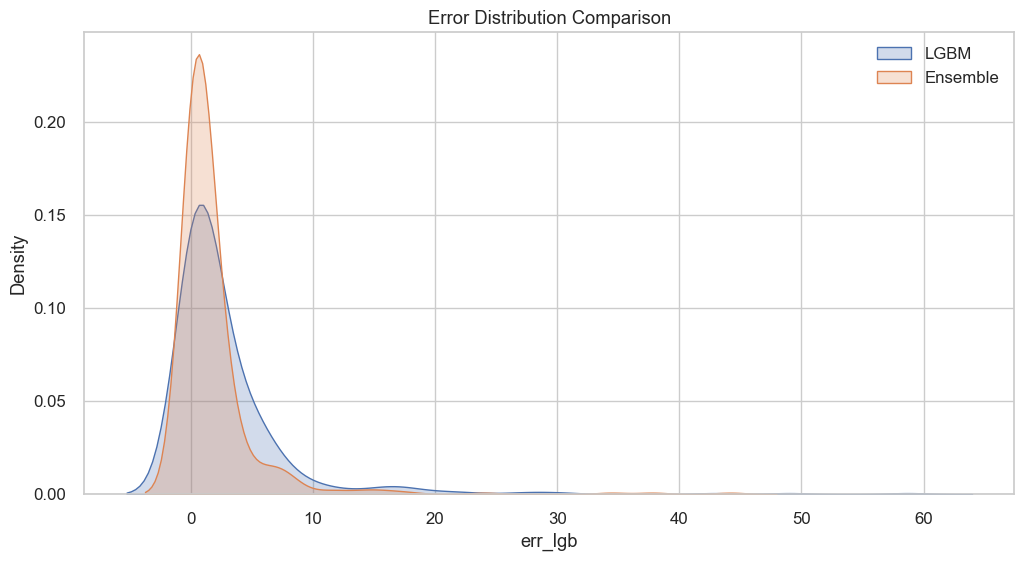

In [53]:
df["err_lgb"] = np.abs(df["actual"] - df["pred_lgb"])
df["err_ens"] = np.abs(df["actual"] - df["pred_ens"])

plt.figure(figsize=(12,6))
sns.kdeplot(df["err_lgb"], label="LGBM", shade=True)
sns.kdeplot(df["err_ens"], label="Ensemble", shade=True)
plt.title("Error Distribution Comparison")
plt.legend()
plt.show()


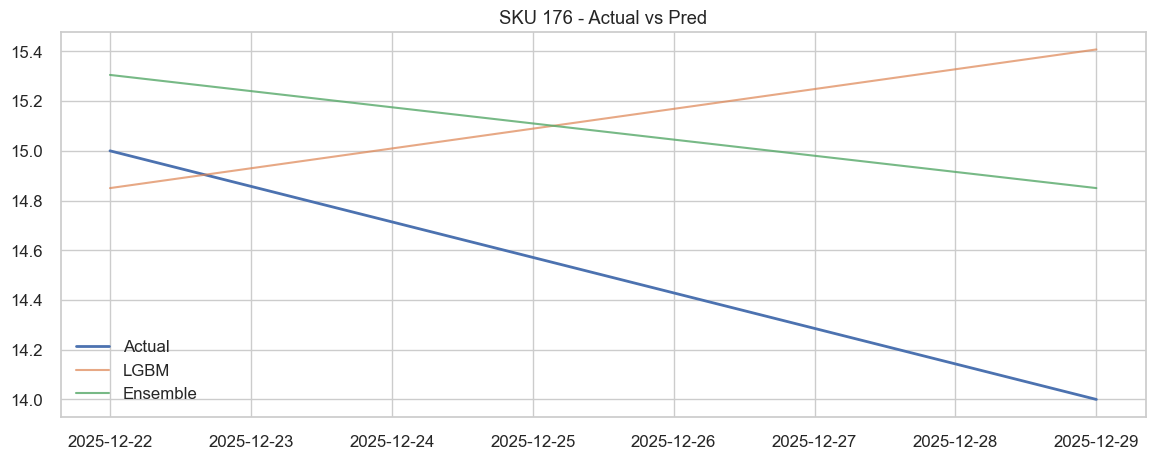

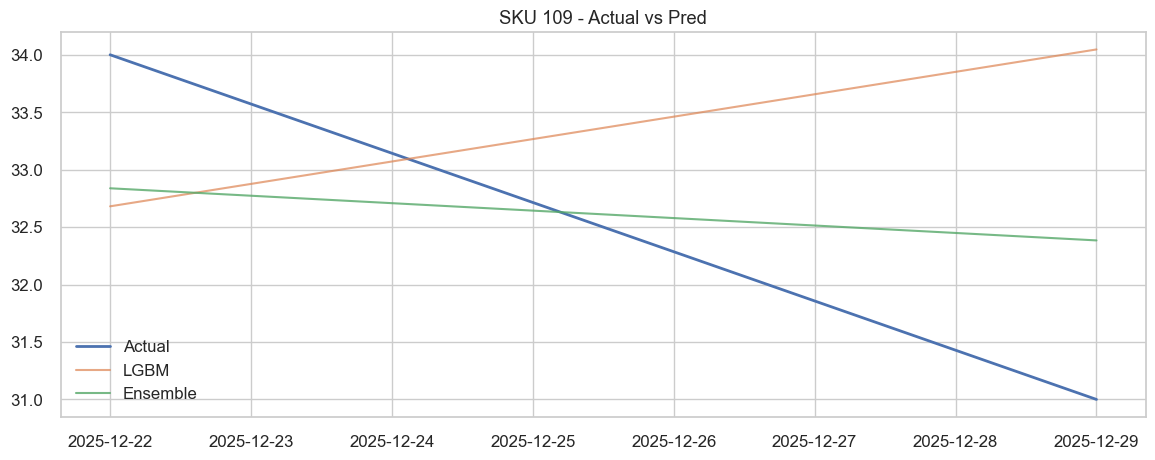

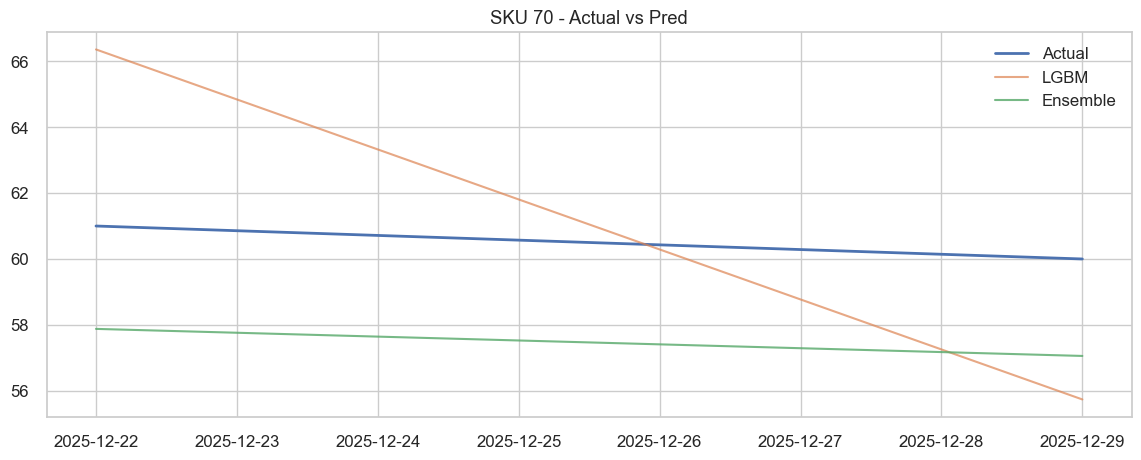

In [54]:
sample_skus = random.sample(df["sku_id"].unique().tolist(), 3)

for sku in sample_skus:
    sub = df[df["sku_id"] == sku].sort_values("target_date")

    plt.figure(figsize=(14,5))
    plt.plot(sub["target_date"], sub["actual"], label="Actual", linewidth=2)
    plt.plot(sub["target_date"], sub["pred_lgb"], label="LGBM", alpha=0.7)
    plt.plot(sub["target_date"], sub["pred_ens"], label="Ensemble", alpha=0.8)

    plt.title(f"SKU {sku} - Actual vs Pred")
    plt.legend()
    plt.grid(True)
    plt.show()


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


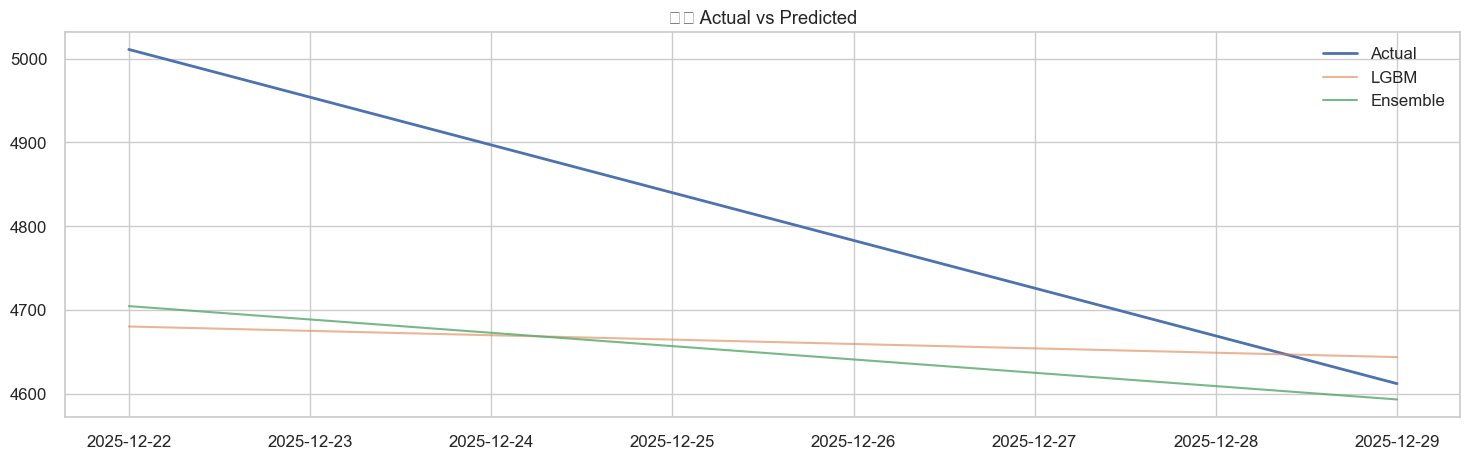

In [55]:
ts = df.groupby("target_date").agg(
    actual_sum=("actual","sum"),
    pred_lgb_sum=("pred_lgb","sum"),
    pred_ens_sum=("pred_ens","sum"),
).reset_index()

plt.figure(figsize=(18,5))
plt.plot(ts["target_date"], ts["actual_sum"], label="Actual", linewidth=2)
plt.plot(ts["target_date"], ts["pred_lgb_sum"], label="LGBM", alpha=0.6)
plt.plot(ts["target_date"], ts["pred_ens_sum"], label="Ensemble", alpha=0.8)
plt.title("전체 Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import random

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

BASE = Path.cwd().parents[1] / "python-server" / "app" / "data_pipeline"


SKU_PATH = BASE / "sku_catalog_ml_with_share.csv"
SALES_PATH = BASE / "weekly_sales.csv"
FEATURES_PATH = BASE / "features_all.csv"
PRED_PATH = BASE / "eval_2025_pred_vs_actual.csv"  

print(SKU_PATH, SALES_PATH, FEATURES_PATH, PRED_PATH)


C:\Users\chosw\ORDER101_251_AI_RE\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\sku_catalog_ml_with_share.csv C:\Users\chosw\ORDER101_251_AI_RE\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\weekly_sales.csv C:\Users\chosw\ORDER101_251_AI_RE\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\features_all.csv C:\Users\chosw\ORDER101_251_AI_RE\be18-fin-SYNERGY-ORDER101\python-server\app\data_pipeline\eval_2025_pred_vs_actual.csv


In [57]:
df_sku = pd.read_csv(SKU_PATH)
df_sales = pd.read_csv(SALES_PATH, parse_dates=["target_date"])
df_feat = pd.read_csv(FEATURES_PATH, parse_dates=["target_date"])
df_pred = pd.read_csv(PRED_PATH, parse_dates=["target_date"])

print("SKU rows:", len(df_sku))
print("Sales rows:", len(df_sales))
print("Features rows:", len(df_feat))
print("Pred rows:", len(df_pred))

df_sales.head()


SKU rows: 206
Sales rows: 53766
Features rows: 52942
Pred rows: 10712


,target_date,warehouse_id,store_id,sku_id,actual_order_qty
0,2021-01-04,1,1,1,0
1,2021-01-04,1,1,2,0
2,2021-01-04,1,1,3,0
3,2021-01-04,1,1,4,0
4,2021-01-04,1,1,5,0


C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\chosw\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtool

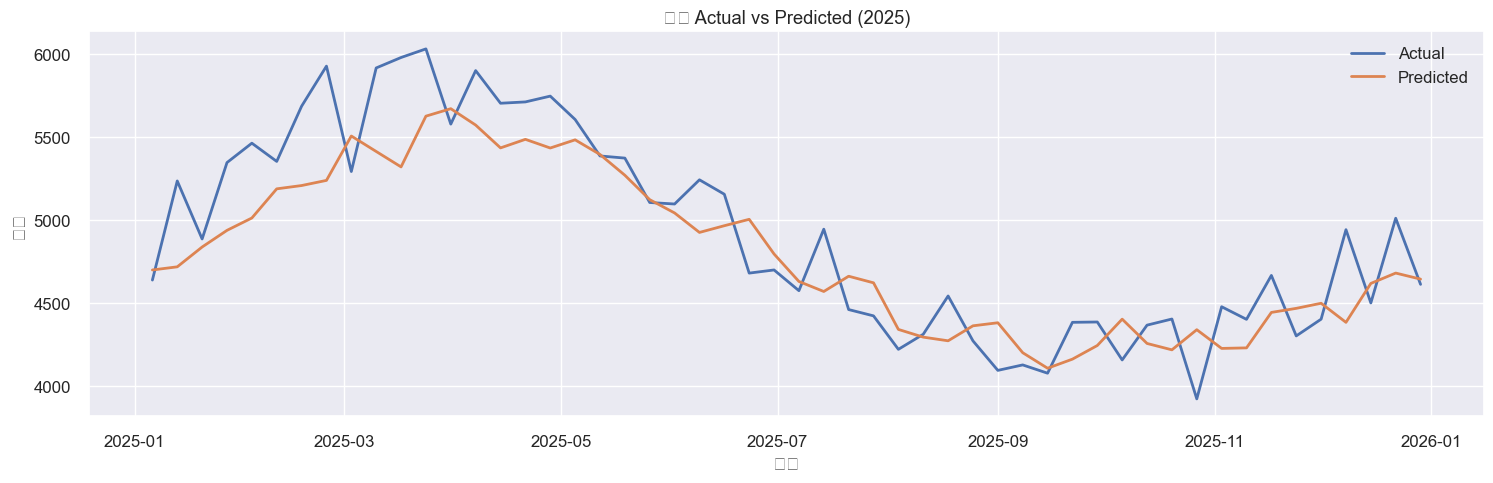

In [58]:
ts_pred = (
    df_pred.groupby("target_date")[["y", "y_pred"]]
    .sum()
    .reset_index()
)

plt.figure(figsize=(18,5))
plt.plot(ts_pred["target_date"], ts_pred["y"], label="Actual", linewidth=2)
plt.plot(ts_pred["target_date"], ts_pred["y_pred"], label="Predicted", linewidth=2)
plt.title("전체 Actual vs Predicted (2025)")
plt.xlabel("날짜")
plt.ylabel("수량")
plt.legend()
plt.grid(True)
plt.show()
